# Functions

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import ShuffleSplit
from scipy import signal
# initialize random Generator for later
rng = np.random.default_rng()

In [14]:
# save an image from the given path to a numpy matrix
def imgRead(path):
  imgIn = plt.imread(path)
  imgIn = imgIn.astype(np.float32)
  return imgIn

In [32]:
# given an image (or block), display it
def imgShow(imagemat, title=None):
  plt.figure()
  plt.axis('off')
  cmap = cm.get_cmap('gray').copy()
  cmap.set_bad(color='red')
  plt.imshow(imagemat, cmap=cmap)
  plt.title(title)

In [16]:
def findBlock(image, x, y, K):
  # extracts the block with its top left corner at the given x, y
  # convert from image coords to python coords (0-indexed)
  pyx = x-1 
  pyy = y-1
  # x and y are flipped since python indexing is row, column
  block = image[pyy:pyy+K, pyx:pyx+K].copy()
  return block

In [17]:
def senseBlock(block, K, S):
  # samples S pixels from the input K x K block, corrupting the rest
  
  # flatten to help with permutation indices
  flat = block.ravel().copy()
  # finds K^2 - S random pixels in the block
  indices = rng.permutation(K**2)[:(K**2)-S]
  for dex in indices:
    # set the lost pixels to NaN (red in the colormap)
    flat[dex] = np.nan
  # find the indices where pixels were lost and where they were sampled
  bad_dex = np.nonzero(np.isnan(flat))
  good_dex = np.nonzero(np.isnan(flat)==0)
  # reshape the block back into a matrix (image chip)
  sensed = flat.reshape((K, K))
  # return the sampled block, the indices that were lost, and the indices that were kept
  return sensed, bad_dex, good_dex

In [18]:
def writeBlock(image, block, x, y, K):
  # writes the input block to the destination image

  # convert from image coords to python coords (0-indexed)
  pyx = x-1 
  pyy = y-1
  # x and y are flipped since python indexing is row, column
  # overwrite the destination image with the block's data at (x, y)
  image[pyy:pyy+K, pyx:pyx+K] = block

In [19]:
def basisvec(u, v, Q, P):
  if u == 1:
    alpha = np.sqrt(1/P)
  else:
    alpha = np.sqrt(2/P)
  if v == 1:
    beta = np.sqrt(1/Q)
  else:
    beta = np.sqrt(2/Q)
  vec = np.empty((Q*P, 1))

  k = 0
  for y in range(1, Q+1):
    for x in range(1, P+1):
      first = np.cos((np.pi * (2*x - 1)*(u - 1)) / (2*P))
      second = np.cos((np.pi * (2*y - 1)*(v - 1)) / (2*Q))
      vec[k] = alpha*beta*first*second
      k += 1

  return vec

In [20]:
def build_basismat(K):
  # Q, P are the pixels in vertical, horizontal directions (rows, columns)
  Q, P = K, K
  # empty matrix to hold basis vectors, K^2 x K^2
  basismat = np.empty((Q**2, P**2))

  k = 0
  for u in range(1, P+1):
    for v in range(1, Q+1):
      basismat[:, [k]] = basisvec(u, v, Q, P)
      k += 1

  return basismat

In [21]:
def displayBasis(u, v, K):
  chip = basisvec(u, v, K, K).reshape((K, K))
  imgShow(chip)

In [81]:
def findAlpha(sampled_basis, sampled_pix, S, plot=False):
  # create a range of reg parameters from 1e-6 to 1e6
  alphas = np.logspace(-6, 6, 37)
  # for each test split, use floor(S/6) test pixels, rest train
  m = np.floor(S/6)
  rs = ShuffleSplit(n_splits=20, test_size=m/S)

  # cross validation with 20 splits per alpha
  model = LassoCV(alphas=alphas, cv=rs).fit(sampled_basis, sampled_pix)
  
  # if needed, plot MSE as a function of reg parameter
  MSEs = np.mean(model.mse_path_, axis=1)
  if plot:
    plt.figure()
    plt.plot(np.log10(model.alphas_), MSEs)
    plt.xlabel('$\log_{10}(\lambda)$')
    plt.ylabel('MSE')
    plt.title('Mean Squared Error vs. Regularization Parameter')

  best = model.alphas_[np.where(MSEs==MSEs.min())]
  if best.shape != 1:
    # maybe condition on if model.alpha_ is greater than .1, choose lowest, if less, choose highest?
    if model.alpha_ > .1:
      best = best[-1]
    if model.alpha_ < .1:
      best = best[0]
  return best

In [23]:
def buildModel(basismat, block, bad, good, K, S, plot=False):
  # cut out the constant column of the basis matrix
  # keep only the rows corresponding to the pixels that were sensed
  A = basismat[good][:, 1:]
  D = block.ravel()[good]

  best_alpha = findAlpha(A, D, S, plot=plot)
  classifier = Lasso(alpha=best_alpha).fit(A, D)

  # use the predicted coefficients and the bases corresponding to missing pixels to predict them
  predicted_pix = classifier.predict(basismat[bad][:, 1:])
  reconstructed = block.ravel().copy()
  reconstructed[bad] = predicted_pix
  reconstructed = reconstructed.reshape((K, K))
  #MSE = np.mean((block - reconstructed)**2)
  #print(f'Alpha: {best_alpha}, MSE: {MSE}')
  return reconstructed, best_alpha

In [93]:
def imgRecover(imgIn, basismat, K, S):
  # main function to recover the input image imgIn
  # basismat for the correct K so that we don't need to recompute
  # blocks are of size K x K
  # S pixels in each block are sampled, the remaining are lost
  # returns the corrupted and recovered images and regularization visulization
    
    corrupted = np.empty(imgIn.shape)
    recovered = np.empty(imgIn.shape)
    x_blocks = int(imgIn.shape[1]/K)
    y_blocks = int(imgIn.shape[0]/K)
    alphas = np.empty(x_blocks*y_blocks) # holds the log10(alpha) for each block to visualize
    
    
    k = 0
    for y in np.arange(1, imgIn.shape[0], K):
        
        for x in np.arange(1, imgIn.shape[1], K):
            block = findBlock(imgIn, x, y, K)
            sensed, bad, good = senseBlock(block, K, S)
            writeBlock(corrupted, sensed, x, y, K)
            reconstruct, alph = buildModel(basismat, block, bad, good, K, S, plot=False)
            writeBlock(recovered, reconstruct, x, y, K)
            alphas[k] = np.log10(alph)
            k += 1
            
    alphas = np.reshape(alphas, (y_blocks, x_blocks))
    return corrupted, recovered, alphas

# Testing and Results

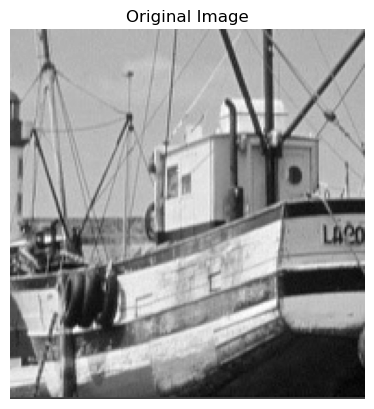

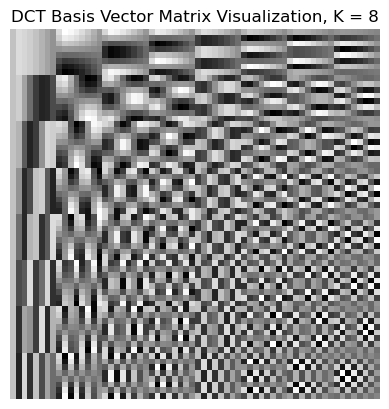

In [106]:
img = imgRead('fishing_boat.bmp')
basismat = build_basismat(8)
imgShow(img, 'Original Image')
imgShow(basismat, 'DCT Basis Vector Matrix Visualization, K = 8')

/Users/matthew/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.847e-02, tolerance: 1.645e-02
  model = cd_fast.enet_coordinate_descent(
/Users/matthew/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.329e+00, tolerance: 1.277e+00
  model = cd_fast.enet_coordinate_descent(
/Users/matthew/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

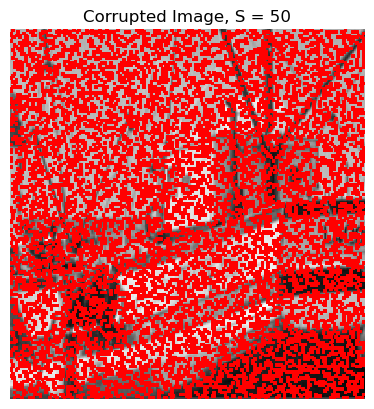

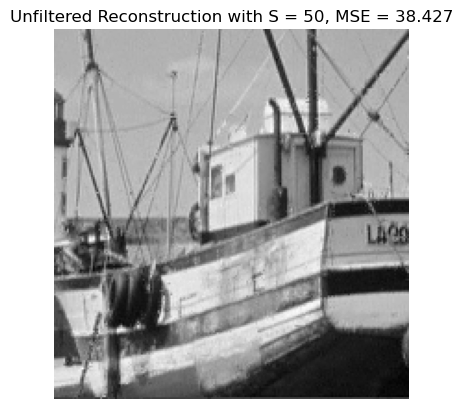

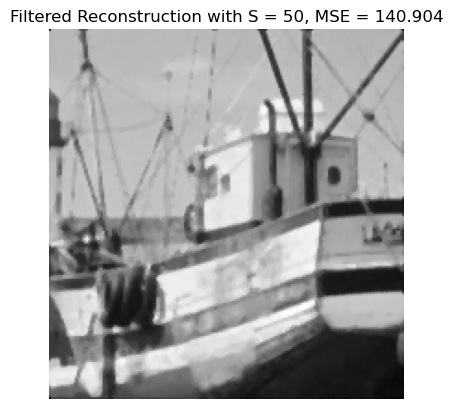

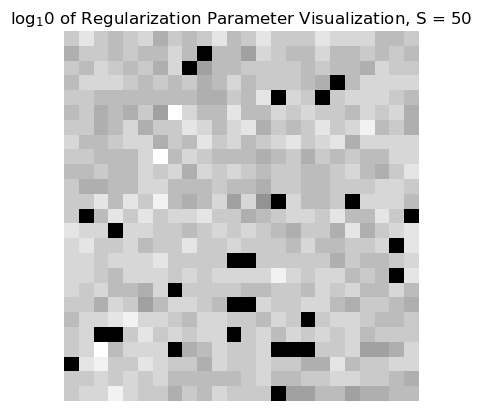

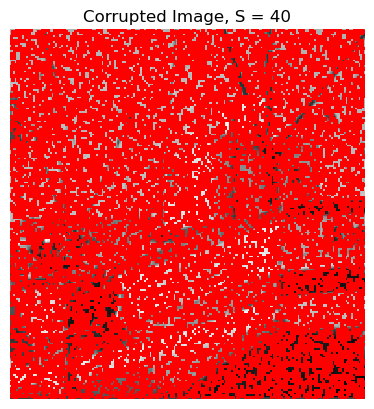

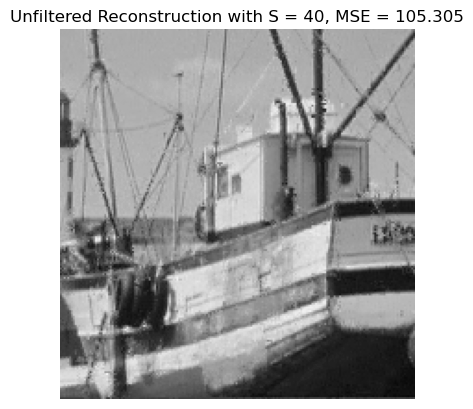

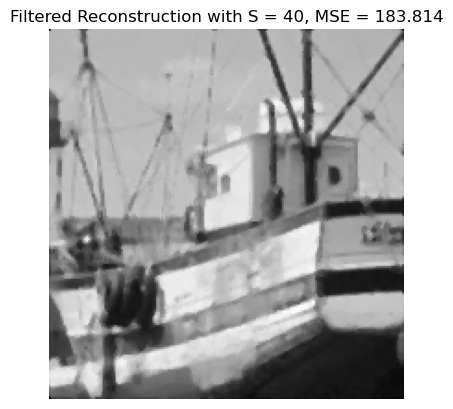

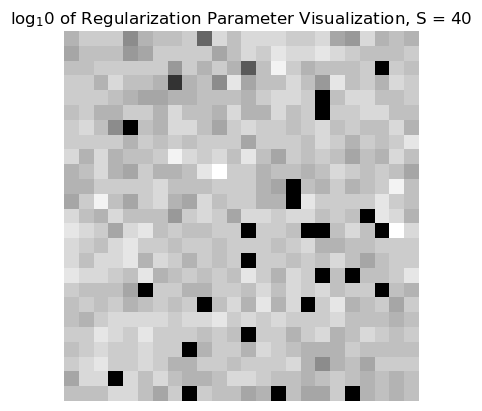

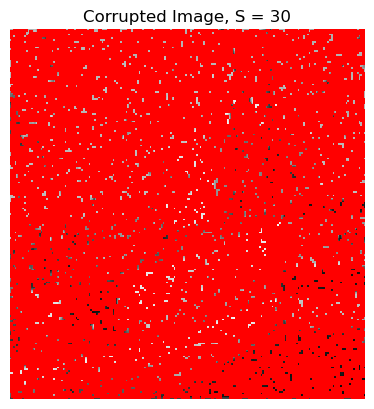

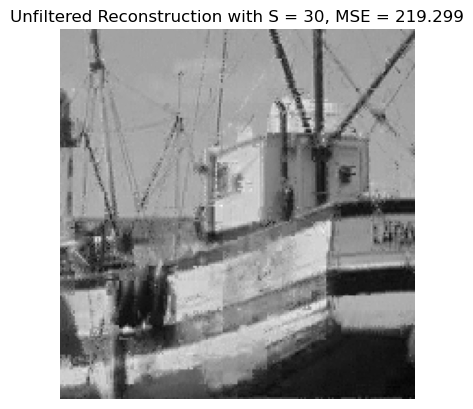

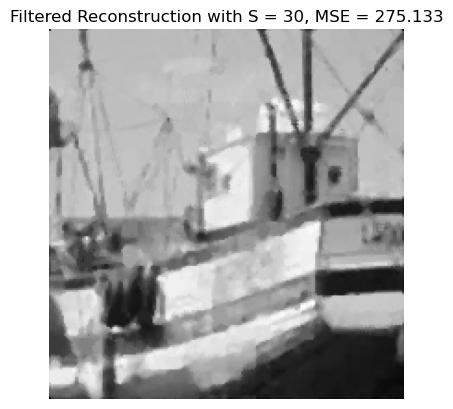

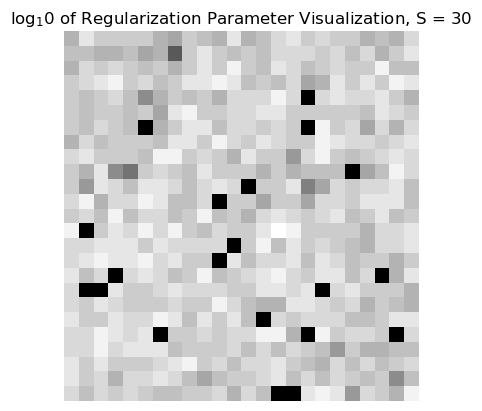

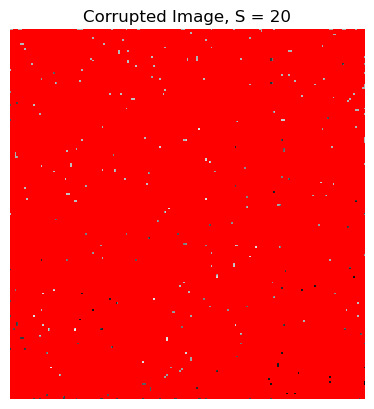

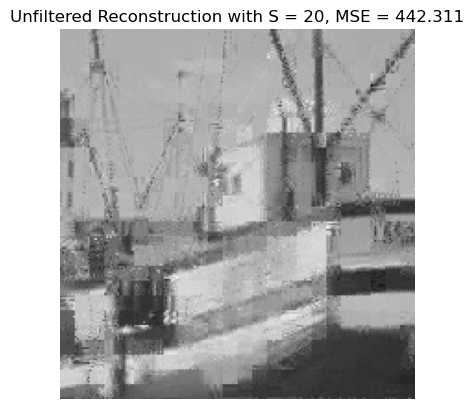

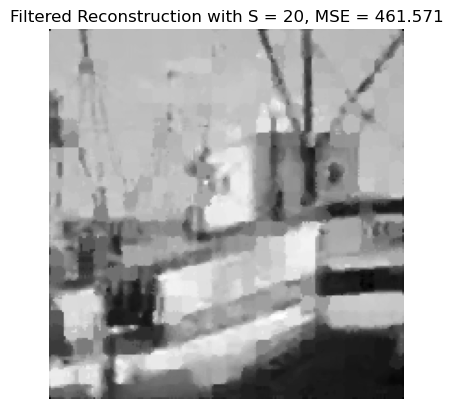

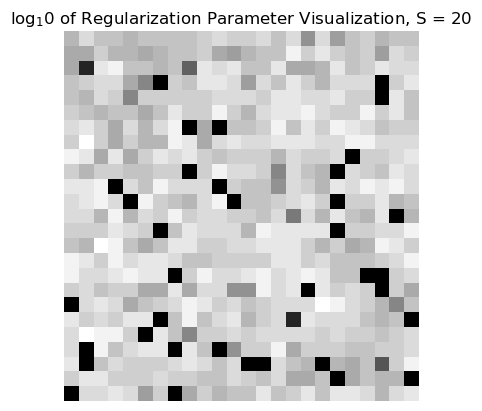

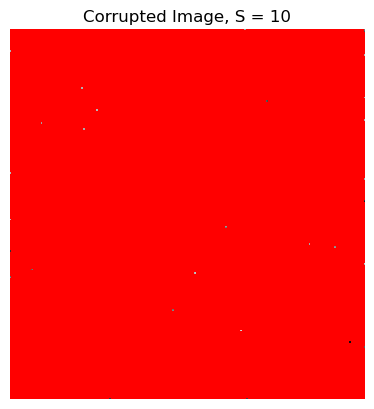

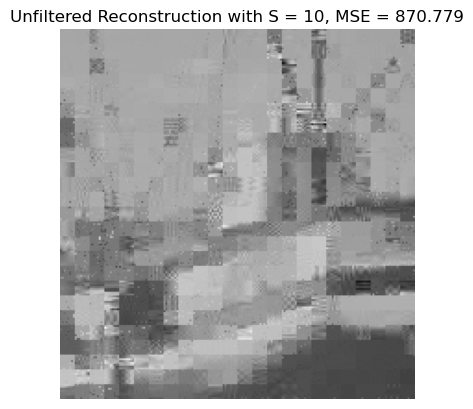

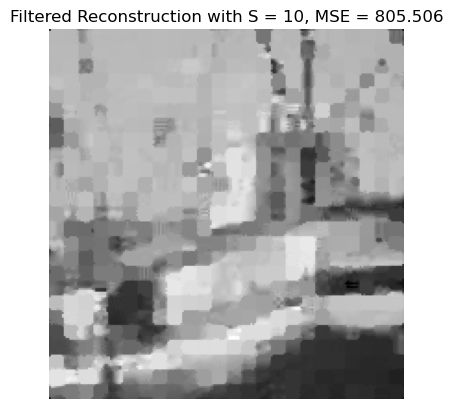

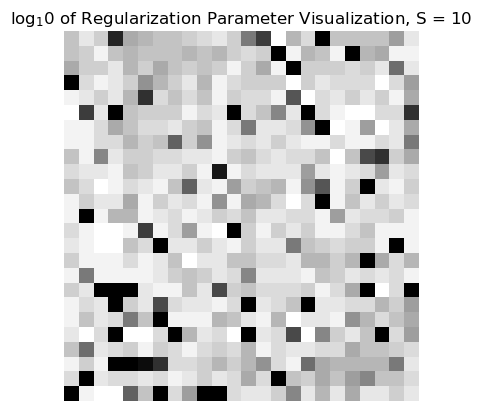

In [107]:
S_list = [50, 40, 30, 20, 10]
K = 8

for S in S_list:
    corrupted, recovered, alphas = imgRecover(img, basismat, K, S)
    MSE = np.mean((img - recovered)**2)
    imgShow(corrupted, f'Corrupted Image, S = {S}')
    imgShow(recovered, title=f'Unfiltered Reconstruction with S = {S}, MSE = {np.round(MSE,3)}')
    filtered = signal.medfilt2d(recovered, kernel_size=3)
    MSE_filtered = np.mean((img - filtered)**2)
    imgShow(filtered, title=f'Filtered Reconstruction with S = {S}, MSE = {np.round(MSE_filtered, 3)}')
    imgShow(alphas, title=f'$\log_{10}$ of Regularization Parameter Visualization, S = {S}')

In [ ]:
# load in images
boat = imgRead('fishing_boat.bmp')
nature = imgRead('nature.bmp')

# image resolutions
print(boat.shape)
print(nature.shape)

# show uncorrupted images
imgShow(boat)
imgShow(nature)

In [ ]:
# Milestone 1: Boat
MyXboat = (8*(len('Matthew') - 1)) + 1
MyYboat = (8*(len('Bloom') - 1)) + 1
print('Boat Block Pixel Coords: ', MyXboat, MyYboat)
K = 8
S = 50
block = findBlock(boat, MyXboat, MyYboat, K)
imgShow(block)
sensed, bad, good = senseBlock(block, K, S)
imgShow(sensed)

In [ ]:
# Milestone 1: Nature
# first initial: M (13)
MyXnature = (16*(13-1)) + 1
# last initial: B (2)
MyYnature = (16*(2-1)) + 1
print('Nature Block Pixel Coords: ', MyXnature, MyYnature)
K = 16
S = 10          
block = findBlock(nature, MyXnature, MyYnature, K)
imgShow(block)
sensed, bad, good = senseBlock(block, K, S)
imgShow(sensed)

In [ ]:
# Milestone 2: Boat
basismat8 = build_basismat(8)
imgShow(basismat8)

In [ ]:
boat = imgRead('fishing_boat.bmp')
MyXboat = (8*(len('Matthew') - 1)) + 1
MyYboat = (8*(len('Bloom') - 1)) + 1

K = 8
S = 40
block = findBlock(boat, MyXboat, MyYboat, K)
sensed, bad, good = senseBlock(block, K, S)
reconstruct, alph = buildModel(basismat8, block, bad, good, K, S, plot=True)
imgShow(reconstruct, title=f'Block LASSO Reconstruction, S={S}')

In [ ]:
# Milestone 2: Nature
basismat16 = build_basismat(16)
imgShow(basismat16)

In [ ]:
nature = imgRead('nature.bmp')
# first initial: M (13)
MyXnature = (16*(13-1)) + 1
# last initial: B (2)
MyYnature = (16*(2-1)) + 1

K = 16
S = 100
block = findBlock(nature, MyXnature, MyYnature, K)
sensed, bad, good = senseBlock(block, K, S)
reconstruct = buildModel(basismat16, block, bad, good, K, S, plot=True)
imgShow(reconstruct)